In [0]:
import numpy as np
from matplotlib import pylab as plt
from queue import Queue, PriorityQueue
import random

In [0]:
def levenstein_dist(s1, s2):
  A = np.zeros((len(s1) + 1, len(s2) + 1))
  A[0, :] = np.arange(len(s2) + 1)
  A[:, 0] = np.arange(len(s1) + 1)
  for i in range(1, len(s1) + 1):
    for j in range(1, len(s2) + 1):
      A[i][j] = min(A[i - 1][j] + 1, A[i][j - 1] + 1, A[i-1][j-1] + (0 if s1[i-1] == s2[j-1] else 1))
  return A[-1][-1]

In [0]:
class WANN:
  class Node:
    def __init__(self, function, parent):
      self.children = PriorityQueue()
      self.function = function
      self.parent = parent

    def __str__(self):
      if self.children.empty():
        return self.function.function.__name__ + '(x)'
      return self.function.function.__name__ + '(' + ', '.join([str(child) for child in self.children.queue]) + ')'

    def str_dfs(self):
      return str(self.function.priority_key) + ''.join([child.str_dfs() for child in self.children.queue])

    def __lt__(self, other):
      return self.function < other.function

    def replace_with_random_subtree(self, nodes_num, childs_num_bounds, function_list):
      new_subtree = WANN()
      new_subtree.generate(nodes_num, childs_num_bounds, function_list)
      new_subtree.top_node.parent = self.parent
      self.parent.children.queue.remove(self)
      self.parent.children.put(new_subtree.top_node)

    def calculate(self, x, param):
      if self.children.empty():
        return self.function.function(param*np.sum(x))
      return self.function.function(param*np.sum([child.calculate(x, param) for child in self.children.queue]))

  def __init__(self):
    self.top_node = -1

  def copy(self):
    return self.get_subtree_copy(self.top_node)

  def get_subtree_copy(self, top_node):
    q = Queue()
    new_wann = WANN()
    new_wann.top_node = self.Node(top_node.function, -1)
    for child in top_node.children.queue:
      q.put((child, new_wann.top_node))
    while not q.empty():
      node, parent = q.get()
      new_node = self.Node(node.function, parent)
      parent.children.put(new_node)
      for child in node.children.queue:
        q.put((child, new_node))
    return new_wann

  def count_nodes(self):
    nodes_num = 0
    q = Queue()
    q.put(self.top_node)
    while not q.empty():
      node = q.get()
      nodes_num += 1
      for child in node.children.queue:
        q.put(child)
    return nodes_num


  def __str__(self):
    return str(self.top_node)

  def str_dfs(self):
      return self.top_node.str_dfs()

  def dist(self, other):
    return levenstein_dist(self.str_dfs(), other.str_dfs())

  def select_random_node(self):
    q = Queue()
    nodes = []
    for child in self.top_node.children.queue:
      q.put(child)
    while not q.empty():
      node = q.get()
      nodes.append(node)
      for child in node.children.queue:
        q.put(child)
    return random.choice(nodes)

  def mutate(self, nodes_num, childs_num_bounds, function_list):
    new_wann = self.copy()
    node = new_wann.select_random_node()
    node.replace_with_random_subtree(nodes_num, childs_num_bounds, function_list)
    return self

  def crossover(self, other):
    new_wann = self.copy()
    node1 = new_wann.select_random_node()
    node2 = other.select_random_node()
    new_subtree = other.get_subtree_copy(node2)
    new_subtree.top_node.parent = node1.parent
    node1.parent.children.queue.remove(node1)
    node1.parent.children.put(new_subtree.top_node)
    return new_wann
  
  def generate(self, nodes_num, childs_num_bounds, function_list):
    if type(nodes_num) == type(tuple):
      nodes_num = np.random.randint(nodes_num[0], nodes_num[1] + 1)
    length = 1
    self.top_node = self.Node(np.random.choice(function_list), -1)
    q = []
    q.append(self.top_node)
    while length < nodes_num:
      node = random.choice(q)
      q.remove(node)
      childs_num = np.random.randint(childs_num_bounds[0], childs_num_bounds[1] + 1)
      for _ in range(childs_num):
        new_child = self.Node(np.random.choice(function_list), node)
        q.append(new_child)
        node.children.put(new_child)
      length += childs_num
    return self

  def calculate(self, x, param):
    return self.top_node.calculate(x, param)

  def err(self, X, Y, params):
    error = 0
    for param in params:
      error += np.linalg.norm(Y - [self.calculate(x, param) for x in X])
    return error/len(params)

In [0]:
class Function:
  def __init__(self, function, priority_key):
    self.function = function
    self.priority_key = priority_key
  
  def __lt__(self, other):
    return self.priority_key < other.priority_key

In [0]:
def diam(T):
  d = 0
  for t1 in T:
    for t2 in T:
      d = max(d, t1.dist(t2))
  return d

def genetic_alg(X, Y, params, population_size, nodes_num, childs_bounds, mutation_nodes_num, function_list, mutations_num, crossovers_num, stagnation_diam, eps):
  population = [WANN().generate(nodes_num, childs_bounds, function_list) for _ in range(population_size)]
  while population[0].err(X, Y, params) > eps:
    mutated = [wann.mutate(mutation_nodes_num, childs_bounds, function_list) for wann in random.sample(population, mutations_num)]
    crossovered = []
    for _ in range(crossovers_num):
      parents = random.sample(population, 2)
      crossovered.append(parents[0].crossover(parents[1]))
    population = population + mutated + crossovered
    population = sorted(population, key=lambda wann: wann.err(X, Y, params))[:population_size]
    if diam(population) <= stagnation_diam:  #stagnation detected!
      for wann in population[population_size//2:]:  #replace the wordst ones with generated
        wann.generate(nodes_num, childs_bounds, function_list)
  return str(population[0])

In [0]:
functions = [np.sin, np.cos]
k = 0
function_list = []
for f in functions:
  function_list.append(Function(f, k))
  k += 1

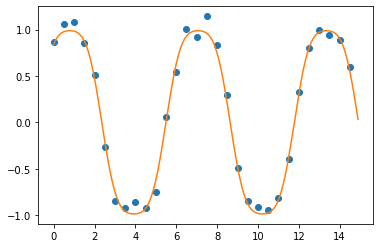

In [7]:
X = np.arange(0, 15, 0.5)
Y = np.sin(np.cos(X) + np.sin(X)) + np.random.randn(30)/15
plt.plot(X, Y, 'o')
plt.plot(np. arange(0, 15, 0.1), np.sin(np.cos(np.arange(0, 15, 0.1)) + np.sin(np.arange(0, 15, 0.1))))

In [14]:
genetic_alg(X, Y, [1], 10, 6, (1, 3), 3, function_list, 3, 3, 0, 1)

'sin(sin(sin(sin(x), sin(x), cos(x))), cos(x))'

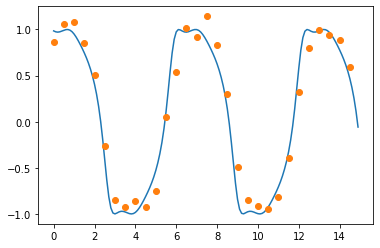

In [18]:
x = np.arange(0, 15, 0.1)
plt.plot(x, np.sin(np.sin(np.sin(np.sin(x) + np.sin(x) + np.cos(x))) + np.cos(x)))
plt.plot(X, Y, 'o')